In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
from scipy.stats import pearsonr,spearmanr

In [3]:
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [4]:
# 截面分位数
def _rank(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num((data_df.rank()/data_df.count()).values.reshape(-1))
    except:
        return np.zeros(len(data))

# 两组数据对应位置上的较大值
def _max(data1,data2):  
    try:
        return np.maximum(data1,data2)
    except:
        return np.zeros(len(data1))

# 两组数据对应位置上的较小值
def _min(data1,data2):  
    try:
        return np.minimum(data1,data2)
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数之和
def _rank_add(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1+rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数之差
def _rank_sub(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1-rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数乘积
def _rank_mul(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1*rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数比值
def _rank_div(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1/rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# shift 1
def _delay1(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.shift(1,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# shift 5
def _delay5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.shift(5,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# diff 1
def _delta1(data):  
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.diff(1,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取std
def _ts_std5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取std
def _ts_std10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取最小值
def _ts_min5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).min()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最小值
def _ts_min10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).min()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取最大值
def _ts_max5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).max()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最大值
def _ts_max10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).max()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最小值
def _ts_cov10(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=10, min_periods=5).cov(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序协方差
def _ts_cov5(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=5, min_periods=2).cov(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

def _ts_corr10(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=10, min_periods=5).corr(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序相关系数
def _ts_corr5(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=5, min_periods=2).corr(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序 mean/std
def _ts_ms10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=10, min_periods=5,axis=1)
        value = roll.mean() / roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_ms5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=5, min_periods=2,aixs=1)
        value = roll.mean() / roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序z分数
def _ts_zscore10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=10, min_periods=5,axis=1)
        value = (data_df - roll.mean())/roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

def _ts_zscore5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=5, min_periods=2,axis=1)
        value = (data_df - roll.mean())/roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序pct_change
def _ts_chg10(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(10, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_chg5(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(5, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_chg1(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(1, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序偏度
def _ts_skew5(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.rolling(5,min_periods=2,axis=1).skew()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_skew10(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.rolling(10,min_periods=5,axis=1).skew()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

rank=make_function(function=_rank,name='rank',arity=1)
max_=make_function(function=_max,name='max_',arity=2)
min_=make_function(function=_min,name='min_',arity=2)
rank_add=make_function(function=_rank_add,name='rank_add',arity=2)
rank_sub=make_function(function=_rank_sub,name='rank_sub',arity=2)
rank_mul=make_function(function=_rank_mul,name='rank_mul',arity=2)
rank_div=make_function(function=_rank_div,name='rank_div',arity=2)
delay1=make_function(function=_delay1,name='delay1',arity=1)
delay5=make_function(function=_delay5,name='delay5',arity=1)
delta1=make_function(function=_delta1,name='delta1',arity=1)
ts_std5=make_function(function=_ts_std5,name='ts_std5',arity=1)
ts_std10=make_function(function=_ts_std10,name='ts_std10',arity=1)
ts_min5=make_function(function=_ts_min5,name='ts_min5',arity=1)
ts_min10=make_function(function=_ts_min10,name='ts_min10',arity=1)
ts_max5=make_function(function=_ts_max5,name='ts_max5',arity=1)
ts_max10=make_function(function=_ts_max10,name='ts_max10',arity=1)
ts_cov10=make_function(function=_ts_cov10,name='ts_cov10',arity=2)
ts_cov5=make_function(function=_ts_cov5,name='ts_cov5',arity=2)
ts_corr10=make_function(function=_ts_corr10,name='ts_corr10',arity=2)
ts_corr5=make_function(function=_ts_corr5,name='ts_corr5',arity=2)
ts_ms10=make_function(function=_ts_ms10,name='ts_ms10',arity=1)
ts_ms5=make_function(function=_ts_ms5,name='ts_ms5',arity=1)
ts_zscore10=make_function(function=_ts_zscore10,name='ts_zscore10',arity=1)
ts_zscore5=make_function(function=_ts_zscore5,name='ts_zscore5',arity=1)
ts_chg10=make_function(function=_ts_chg10,name='ts_chg10',arity=1)
ts_chg5=make_function(function=_ts_chg5,name='ts_chg5',arity=1)
ts_chg1=make_function(function=_ts_chg1,name='ts_chg1',arity=1)
ts_skew10=make_function(function=_ts_skew10,name='ts_skew10',arity=1)
ts_skew5=make_function(function=_ts_skew5,name='ts_skew5',arity=1)

In [5]:
post=ff.read('post')
filter0=ff.filter0
close=ff.read('close')*post*filter0
open_=ff.read('open')*post*filter0
high=ff.read('high')*post*filter0
low=ff.read('low')*post*filter0
vol=ff.read('vol')*filter0
amount=ff.read('amount')*post*filter0

In [6]:
inds = pd.read_pickle('/mydata2/wangs/data/dict_ind_matrix_sw1.pk')

In [7]:
result = pd.DataFrame(columns=['因子','夏普率','收益率','mkt_'])

In [8]:
mkv=(ff.read('mkv','factor')*filter0).loc[close.index,'20200101':'20210101']
mkv_s=mkv.values.reshape(-1)

In [9]:
mkt20=close.shift(-10,axis=1)/close - 1

In [10]:
factor_names1=['closer', 'openr', 'lowr', 'highr', 'ocret', 'lcret', 'hcret', 'ohret', 'ret5', 'ret10', 'ret20', 'ret30', 'excess5', 'excess10', 'excess20', 'excess30', 'ma5', 'bias5', 'ma10',
               'bias10', 'ma15', 'bias15', 'ma20', 'bias20', 'vwap_ret', 'vwaph_ret', 'll5', 'll15', 'll20', 'll30', 'a0', 'a5', 'a15', 'a30', 'ah5', 'ah10', 'ah15', 'std', 'amt_std', 'vol_std', 
               'amt_mean', 'vol_mean', 'turnover', 'turnover_mean', 'turnover_std', 'turnover_skew', 'turnoverf', 'turnoverf_mean', 'turnoverf_std', 'turnoverf_skew', 'mkv', 'l_mkv', 'lhret', 
               'STR', 'MTR', 'SMTR', 'ILLIQ','close','high','low']
factor_names2=['ARRP', 'ARRP_5d_20mean', 'AmpMod', 'BVol', 'CDPDVP', 'ILLIQ', 'IVoldeCorr', 'IntraDayMom20', 'MTR', 'RCP', 'SMTR', 'SPS', 'STR', 'a30', 
               'afternoon_ratio_1', 'ah15', 'amt', 'amt_ma20', 'amt_mean', 'amt_score0', 'amt_score1', 'amt_score2', 'amt_std', 'amt_std20', 'bias10', 'bias15', 'bias20', 'bias5', 
               'cross_std10', 'cross_std10adj', 'ctrade', 'excess10', 'excess20', 'excess30', 'excess5', 'growth_a', 'growth_b', 'growth_c', 'h_rankamt_corr_10', 'h_rankv_corr_10', 'h_rankv_corr_36', 
               'hcret', 'idiov', 'intro_high80_corr', 'ivr', 'l_mkv', 'mkv', 'mom1', 'mom_spring', 'nl_mkv', 'nl_mom', 'open0931ratio', 'open5ratio_ma10vol', 'rank_2_corr_hv10', 'rank_2_corr_hv20', 'rank_ha_corr_sum', 
               'ret20', 'ret30', 'ret5', 'roc121', 'roc20', 'roc240', 'roc5', 'scr', 'std', 'std20', 'std21', 'std240', 'stddev_cov', 'stddev_cov_right', 'sub', 'sysv', 'tail_ratio_1', 'tailrets0', 'tailrets1', 'tliq', 
               'turn20', 'turnover', 'turnover_mean', 'turnover_scale_z', 'turnover_score_ts_mean', 'turnover_score_ts_std', 'turnover_skew', 'turnover_std', 'turnoverf', 'turnoverf_mean', 'turnoverf_skew', 'turnoverf_std', 
               'up_KURS', 'up_plus_down_KURS', 'vol', 'vol_mean', 'vol_std', 'vol_std20', 'volroc_skew', '滞后日内量价corr']
factor_name3 =['accelerated_turnover_rank_RC','CSK_XYY_UP_DOWN_120D_RC','high_fre_vol_RC','high_fre_diff_vol_RC','high_fre_absdiff_vol_RC','peak_count_vol_RC','overnightsmart20_RC','CTR_RC','jumpCTR_RC','turnover_rate_proportion_l','synergy']
factor_name4 = ['ll60','ll120', 'lr5', 'lr10', 'lr20', 'lr30','lr60','lr120','posi60','posi120','posi240','nhigh20','nhigh60', 'nhigh120','nhigh20','nhigh60','nhigh120']
factor_name5 = ['rtn_condVaR', 'CTR_RC', 'jumpCTR_RC', 'openr', 'CCOIV', 'lr30', 'SZXZ', 'vol_DW', 'buy_sm_amount', 'lr20', 'TCV', 'ah10', 'buy_elg_amount', 'ret10', 'vol_LBQ', 'ah5', 'lr120', 'ma15', 'correlation_matrix13', 'high_fre_diff_vol', 'posi120', 'nlow60', 'roc30', 'accelerated_turnover_rank', 'VolStd', 'low', 'sell_sm_amount', 'vwap_ret', 'rtn_DW', 'high', 'sell_md_amount', 'll5', 'SBZL', 'lhret', 'nhigh120', 'SQ', 'draw30', 'lr60', 'SPR', 'close', 'rtn_LBQ', 'WBGM', 'closer', 'SCOV', 'll60', 'feph', 'ID_Vol_deCorr', 'highr', 'NCV', 'buy_md_amount', 'lcret', 'SCCOIV', 'VoPC', 'highStdRtn_meanN', 'lowr', 'up', 'nhigh20', 'll20', 'high_fre_vol', 'ma5', 'ZMCW', 'bias30', 'high_fre_absdiff_vol', 'a5', 'nlow120', 'UID', 'll15', 'sell_elg_amount', 'posi60', 'a0', 'ma20', 'roc60', 'correlation_matrix12', 'overnightsmart20_RC', 'peak_count_vol', 'roc15', 'lr10', 'VoWVR', 'rtn_rho', 'nhigh60', 'down', 'posi240', 'foc_Comb', 'vwaph_ret', 'vol_rho', 'GYCQ', 'draw60', 'up_limit', 'post', 'PCV', 'UTD10', 'RPV', 'buy_lg_amount', 'draw15', 'ocret', 'ma10', 'll30', 'rtn_foc', 'sell_lg_amount', 'vwap', 'YMSL', 'ohret', 'net_mf_amount', 'DW_Comb', 'market_mean_IV', 'CSK_XYY_UP_DOWN_120D', 'correlation_matrix11', 'down_limit', 'HYLJ', 'nlow20', 'bias60', 'SRV', 'LBQ_Comb', 'UTD20', 'open', 'a15', 'COYCYV', 'rho_Comb', 'll120', 'highStdRtn_mean', 'lr5', 'vol_foc']
fields = factor_names1 + factor_names2 + factor_name3 + factor_name4 + factor_name5
fields = list(set(fields))

In [11]:
stock_test=pd.DataFrame()
for factor in fields:
    # stock_test[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns).values.reshape(-1)
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns)
    stock_test[factor] = (data.rank()/data.count()).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20210101'].columns]
test_date=close.loc[:,'20200101':'20210101'].columns.to_list() *len(close.index)
stock_test['code']=test_code
stock_test['date']=test_date
stock_test['1'],stock_test['5'],stock_test['10'],stock_test['20'],stock_test['40'],stock_test['60']=1,5,10,20,40,60

In [12]:
stock_test

,high_fre_diff_vol_RC,highStdRtn_meanN,SPR,peak_count_vol_RC,h_rankamt_corr_10,accelerated_turnover_rank,UID,PCV,nlow120,roc20,...,scr,ll15,code,date,1,5,10,20,40,60
0,NaN,0.872851,0.265107,NaN,0.594276,0.308507,NaN,0.879464,0.182235,0.673843,...,0.231858,NaN,000001.SZ,20200102,1,5,10,20,40,60
1,NaN,0.508585,0.482412,0.034279,0.376328,0.331146,NaN,0.432769,0.182772,0.753538,...,0.247420,NaN,000001.SZ,20200103,1,5,10,20,40,60
2,NaN,0.814057,0.358452,0.207595,0.124557,0.312649,NaN,0.773551,0.183215,0.655366,...,0.162441,NaN,000001.SZ,20200106,1,5,10,20,40,60
3,NaN,0.323556,0.459835,0.210130,0.097403,0.223614,NaN,0.551591,0.183402,0.706541,...,0.157631,NaN,000001.SZ,20200107,1,5,10,20,40,60
4,NaN,0.422610,0.477427,0.461493,0.054014,0.250298,NaN,0.927661,0.183240,0.674713,...,0.177804,NaN,000001.SZ,20200108,1,5,10,20,40,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201225,1,5,10,20,40,60
1347188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201228,1,5,10,20,40,60
1347189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201229,1,5,10,20,40,60
1347190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201230,1,5,10,20,40,60


In [13]:
# test_mkt=mkt20.loc[:,'20200101':'20210101'].values.reshape(-1)
test_mkt=(mkt20.loc[:,'20200101':'20210101'].rank()/mkt20.loc[:,'20200101':'20210101'].count()).values.reshape(-1)

In [14]:
import statsmodels.api as sm

def rankIC_metric(y,y_pred,w=None):
    
    def cal_rankIC(df):
        df.index=df.code
        # 去极值
        M=df.y_pred.mean()    #df.y_pred.median()
        M1=df.y_pred.std()    #(df.y_pred-M).abs().median()
        df.y_pred.loc[df.y_pred>M+3*M1]=M+3*M1    #5
        df.y_pred.loc[df.y_pred<M-3*M1]=M-3*M1
        # 行业市值中性化
        day=df.date.iloc[0]
        ind=inds[day].copy()
        ind['mkv']=df.loc[ind.index,'mkv']
        input_x=ind.dropna().astype(float)
        input_y=df.loc[input_x.index,'y_pred']
        y_true=df.loc[input_x.index,'y'].values
        if len(input_x)==0:
            return 0
        else:
            mod=sm.OLS(input_y,input_x)
            res=mod.fit()
            y_adj=res.resid
            #标准化
            y_adj=(y_adj-y_adj.mean())/y_adj.std()
        
            if len(np.unique(y_adj.values)) <=2:
                return 0
            else:
                #return y_adj.corr(input_xy.mkt_delay,method='spearman')
                return spearmanr(np.nan_to_num(y_adj.values),np.nan_to_num(y_true))[0]
            
    if len(np.unique(y_pred))<=2:
        return 0
    else:
        try:
            data=pd.DataFrame({'y_pred':y_pred,'y':y,'mkv':np.log(mkv_s),'code':test_code,'date':test_date})
            res=data.groupby('date').apply(cal_rankIC)
            return np.abs(np.nanmean(res))
        except:
            return 0

In [15]:
rankIC=make_fitness(function=rankIC_metric,greater_is_better=True)

In [16]:
function_set = ['add','sub','mul','div','sqrt','log','inv','abs','neg',rank,max_,min_,rank_add,rank_sub,rank_mul,rank_div,delay1,delay5,delta1,ts_std5,ts_std10,ts_min5,ts_min10,ts_max5,ts_max10,ts_cov10,ts_cov5,ts_corr10,ts_corr5,ts_ms10,ts_ms5,ts_zscore10,ts_zscore5,ts_chg10,ts_chg5,ts_chg1,ts_skew10,ts_skew5]

In [17]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 4, #进化代数
                            population_size = 5000, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=rankIC,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6)

In [18]:
import psutil
import os
print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )
info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3))
print(u'当前使用的总内存占比：', info.percent)
print(u'cpu个数：', psutil.cpu_count())

当前进程的内存使用：9.1055 GB
电脑总内存：1007.4503 GB
当前使用的总内存占比： 63.5
cpu个数： 256


In [19]:
test_gp.fit(np.nan_to_num(stock_test.loc[:,fields].values),np.nan_to_num(test_mkt))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 19.4min remaining: 38.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 21.5min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     4.27       0.00659408        2        0.0887486              N/A     64.40m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 94.8min remaining: 189.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 103.9min finished


   1     4.42        0.0368052        2        0.0887486              N/A    207.75m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 81.0min remaining: 162.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 103.6min finished


   2     4.22        0.0660307        7         0.101693              N/A    103.56m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 93.8min remaining: 187.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 95.7min finished


   3     6.87        0.0723289        7         0.102416              N/A      0.00s


SymbolicTransformer(const_range=None,
                    feature_names=['high_fre_diff_vol_RC', 'highStdRtn_meanN',
                                   'SPR', 'peak_count_vol_RC',
                                   'h_rankamt_corr_10',
                                   'accelerated_turnover_rank', 'UID', 'PCV',
                                   'nlow120', 'roc20', 'market_mean_IV', 'lowr',
                                   'YMSL', 'rank_2_corr_hv10', 'std21',
                                   'high_fre_vol_RC', 'vol_foc', 'volroc_skew',
                                   'turnover_scale_z', 'vol_std', 'tailrets0',
                                   'high_fre_v...
                                  <gplearn.functions._Function object at 0x7f53a2e29a90>,
                                  <gplearn.functions._Function object at 0x7f53a2e29b50>, ...],
                    generations=4, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7f5334b04310>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=5000,
                    tournament_size=10, verbose=2)

In [38]:
stock_all=pd.DataFrame()
for factor in fields:
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)
    stock_all[factor] = (data.rank()/data.count()).values.reshape(-1)
    # stock_all[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20240101'].columns]
test_date=close.loc[:,'20200101':'20240101'].columns.to_list() *len(close.index)
stock_all['code']=test_code
stock_all['date']=test_date
stock_all['1'],stock_all['5'],stock_all['10'],stock_all['20'],stock_all['40'],stock_all['60']=1,5,10,20,40,60

Program 1: add(add(max_(up_plus_down_KURS, SMTR), foc_Comb), stddev_cov_right)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


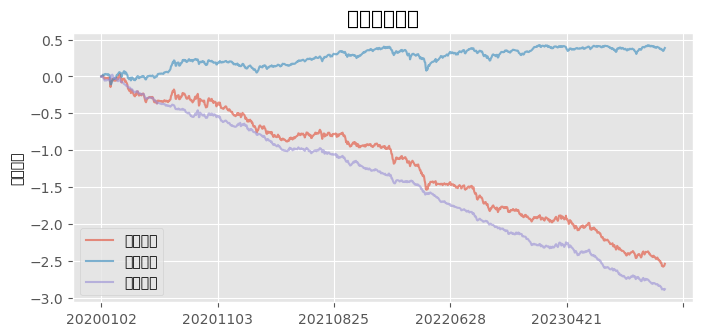

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.742,-0.653
年化波动率,0.201,0.187,0.313
夏普率,0.495,-3.965,-2.087
最大回撤,-0.325,-2.915,-2.605
收益回撤比,0.305,-0.255,-0.251
胜率,0.534,0.399,0.480
盈亏比,0.948,0.782,0.765


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


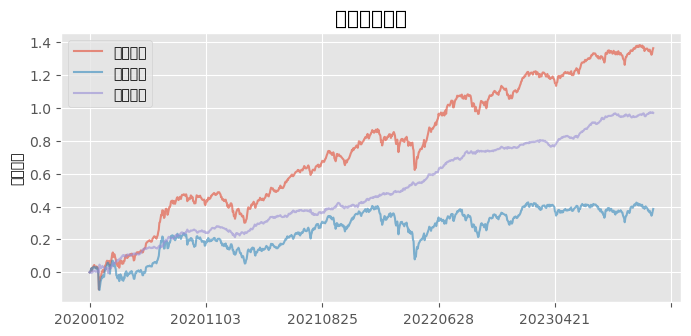

,指数收益,超额收益,策略收益
年化收益率,0.099,0.250,0.352
年化波动率,0.201,0.075,0.203
夏普率,0.495,3.345,1.730
最大回撤,-0.325,-0.068,-0.249
收益回撤比,0.305,3.704,1.411
胜率,0.534,0.581,0.578
盈亏比,0.948,1.266,0.982


Program 2: max_(delay1(div(ts_chg5(excess30), ts_zscore5(WBGM))), add(max_(up_plus_down_KURS, SMTR), sub(turnoverf, high)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


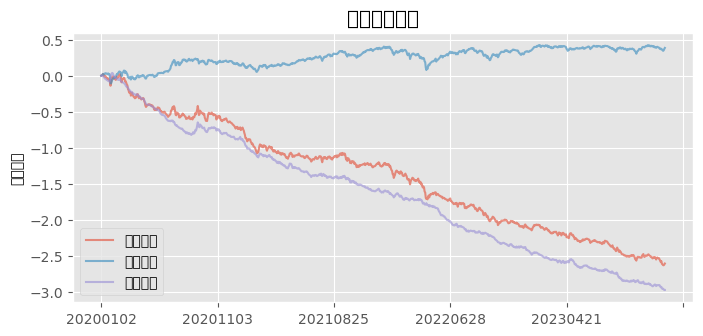

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.767,-0.672
年化波动率,0.201,0.165,0.279
夏普率,0.495,-4.640,-2.411
最大回撤,-0.325,-3.013,-2.652
收益回撤比,0.305,-0.254,-0.253
胜率,0.534,0.359,0.441
盈亏比,0.948,0.831,0.846


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


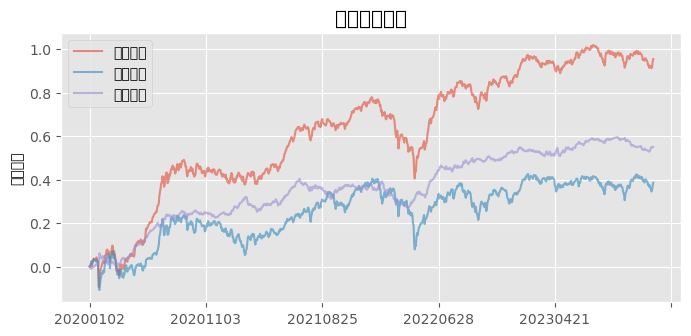

,指数收益,超额收益,策略收益
年化收益率,0.099,0.142,0.246
年化波动率,0.201,0.090,0.196
夏普率,0.495,1.579,1.252
最大回撤,-0.325,-0.132,-0.373
收益回撤比,0.305,1.070,0.660
胜率,0.534,0.542,0.545
盈亏比,0.948,1.102,1.033


Program 3: neg(add(abs(SPR), turnover))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


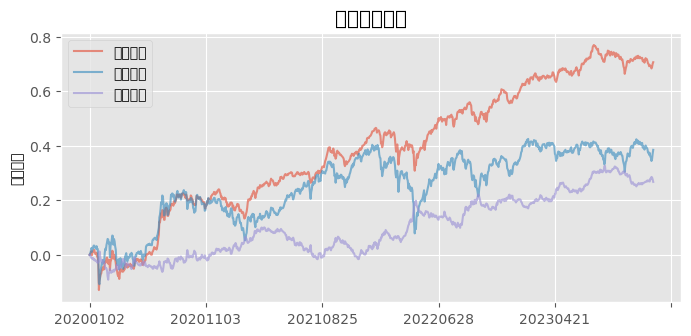

,指数收益,超额收益,策略收益
年化收益率,0.099,0.069,0.182
年化波动率,0.201,0.105,0.152
夏普率,0.495,0.660,1.198
最大回撤,-0.325,-0.117,-0.157
收益回撤比,0.305,0.591,1.158
胜率,0.534,0.479,0.561
盈亏比,0.948,1.208,0.973


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


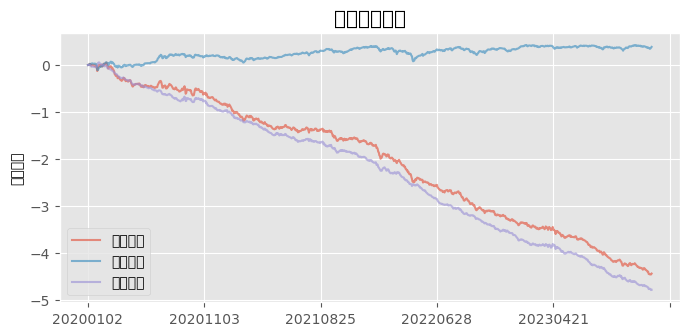

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.233,-1.143
年化波动率,0.201,0.226,0.336
夏普率,0.495,-5.464,-3.403
最大回撤,-0.325,-4.844,-4.508
收益回撤比,0.305,-0.254,-0.254
胜率,0.534,0.362,0.432
盈亏比,0.948,0.714,0.745


Program 4: log(add(add(delay1(roc121), foc_Comb), stddev_cov_right))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


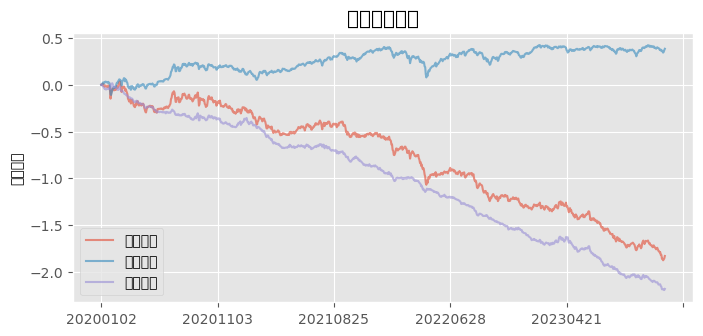

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.563,-0.472
年化波动率,0.201,0.159,0.289
夏普率,0.495,-3.550,-1.635
最大回撤,-0.325,-2.212,-1.913
收益回撤比,0.305,-0.254,-0.247
胜率,0.534,0.408,0.482
盈亏比,0.948,0.798,0.815


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


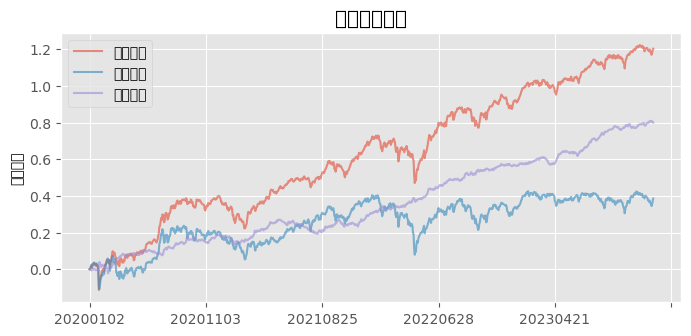

,指数收益,超额收益,策略收益
年化收益率,0.099,0.206,0.310
年化波动率,0.201,0.080,0.193
夏普率,0.495,2.592,1.609
最大回撤,-0.325,-0.078,-0.259
收益回撤比,0.305,2.654,1.197
胜率,0.534,0.547,0.568
盈亏比,0.948,1.273,1.007


Program 5: add(buy_md_amount, max_(turnover_scale_z, STR))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


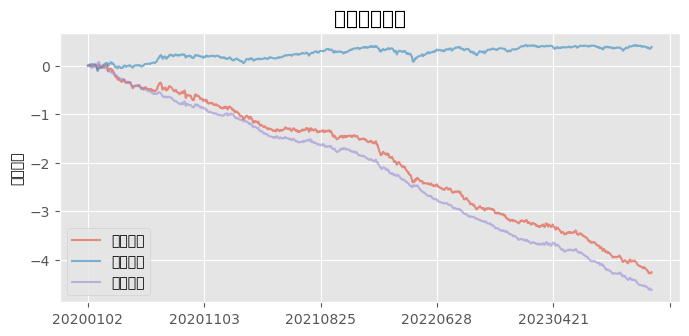

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.190,-1.097
年化波动率,0.201,0.205,0.309
夏普率,0.495,-5.804,-3.544
最大回撤,-0.325,-4.696,-4.302
收益回撤比,0.305,-0.253,-0.255
胜率,0.534,0.344,0.411
盈亏比,0.948,0.733,0.799


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


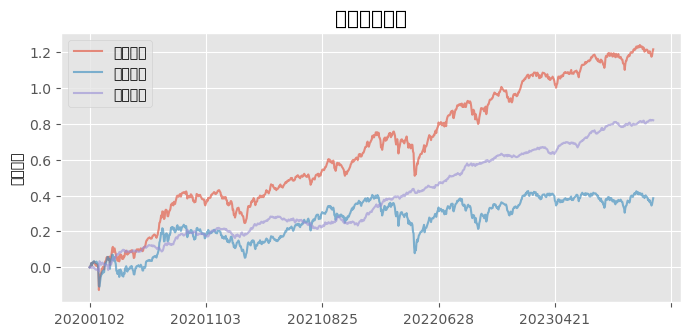

,指数收益,超额收益,策略收益
年化收益率,0.099,0.211,0.313
年化波动率,0.201,0.081,0.204
夏普率,0.495,2.604,1.539
最大回撤,-0.325,-0.069,-0.247
收益回撤比,0.305,3.046,1.269
胜率,0.534,0.567,0.581
盈亏比,0.948,1.183,0.940


Program 6: add(turnoverf_mean, sub(turnoverf, high))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


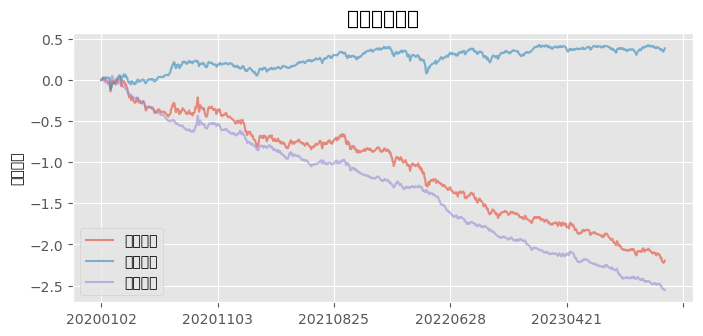

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.658,-0.566
年化波动率,0.201,0.182,0.299
夏普率,0.495,-3.609,-1.892
最大回撤,-0.325,-2.604,-2.259
收益回撤比,0.305,-0.253,-0.251
胜率,0.534,0.400,0.449
盈亏比,0.948,0.814,0.889


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


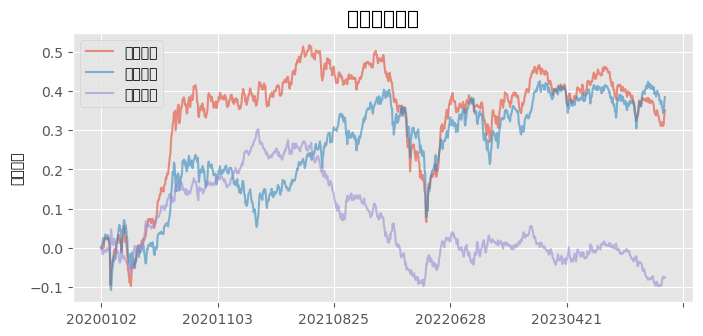

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.019,0.090
年化波动率,0.201,0.120,0.183
夏普率,0.495,-0.162,0.494
最大回撤,-0.325,-0.402,-0.452
收益回撤比,0.305,-0.048,0.200
胜率,0.534,0.490,0.514
盈亏比,0.948,1.013,1.025


Program 7: max_(max_(up_plus_down_KURS, SMTR), max_(bias15, vol_std))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


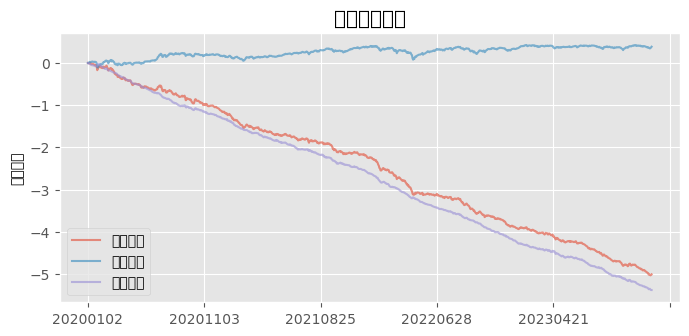

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.386,-1.291
年化波动率,0.201,0.137,0.260
夏普率,0.495,-10.112,-4.967
最大回撤,-0.325,-5.368,-5.031
收益回撤比,0.305,-0.258,-0.257
胜率,0.534,0.244,0.386
盈亏比,0.948,0.579,0.694


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


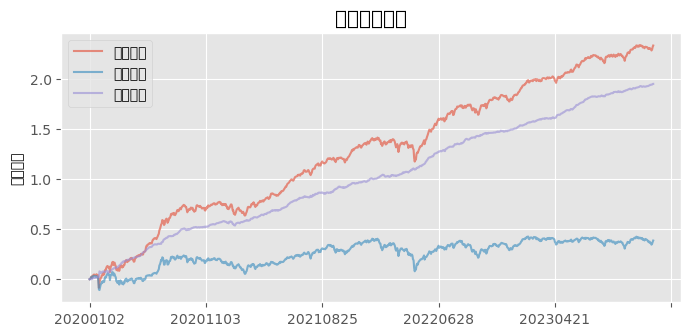

,指数收益,超额收益,策略收益
年化收益率,0.099,0.502,0.600
年化波动率,0.201,0.070,0.215
夏普率,0.495,7.160,2.789
最大回撤,-0.325,-0.044,-0.240
收益回撤比,0.305,11.315,2.504
胜率,0.534,0.706,0.623
盈亏比,0.948,1.546,0.976


Program 8: add(log(sell_md_amount), sqrt(SMTR))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


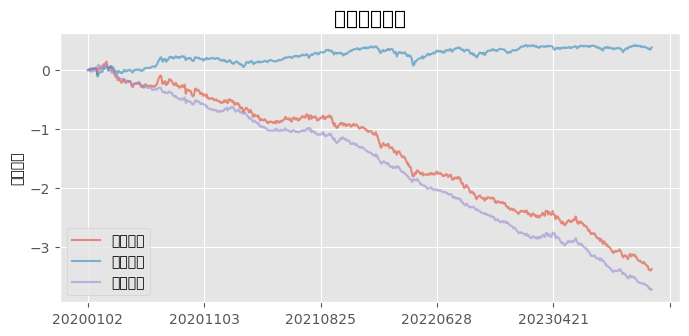

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.958,-0.869
年化波动率,0.201,0.224,0.333
夏普率,0.495,-4.285,-2.605
最大回撤,-0.325,-3.814,-3.539
收益回撤比,0.305,-0.251,-0.245
胜率,0.534,0.385,0.436
盈亏比,0.948,0.791,0.841


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


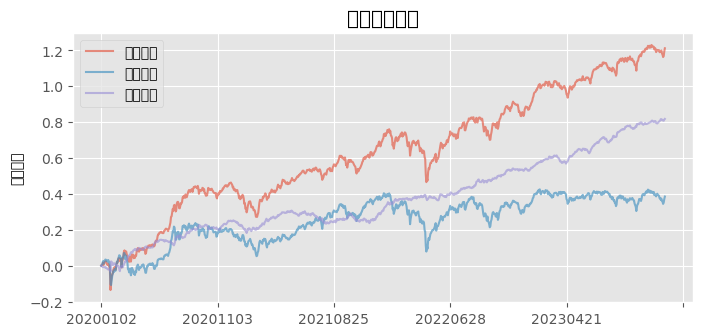

,指数收益,超额收益,策略收益
年化收益率,0.099,0.211,0.312
年化波动率,0.201,0.082,0.206
夏普率,0.495,2.583,1.519
最大回撤,-0.325,-0.072,-0.295
收益回撤比,0.305,2.910,1.058
胜率,0.534,0.551,0.566
盈亏比,0.948,1.265,0.998


Program 9: sub(add(turnoverf_mean, market_mean_IV), high)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


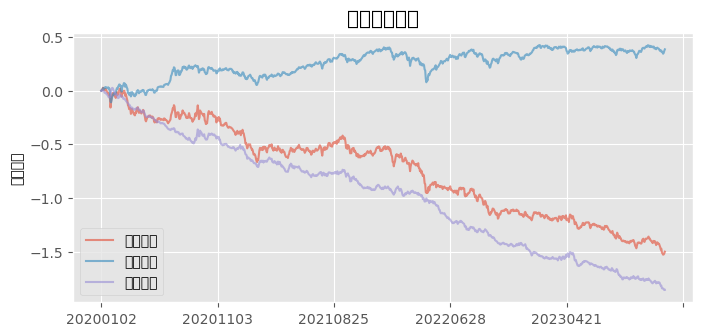

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.478,-0.387
年化波动率,0.201,0.165,0.289
夏普率,0.495,-2.892,-1.337
最大回撤,-0.325,-1.884,-1.555
收益回撤比,0.305,-0.254,-0.249
胜率,0.534,0.415,0.465
盈亏比,0.948,0.870,0.918


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


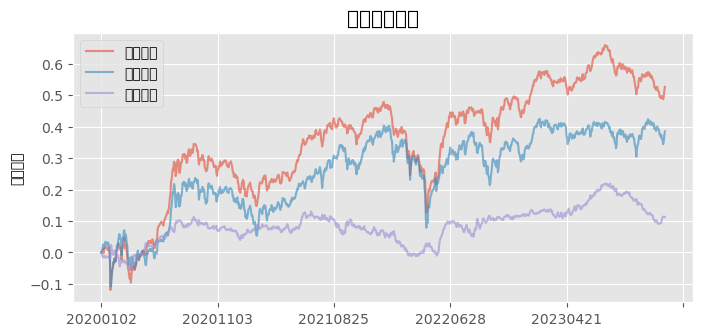

,指数收益,超额收益,策略收益
年化收益率,0.099,0.029,0.136
年化波动率,0.201,0.087,0.181
夏普率,0.495,0.336,0.751
最大回撤,-0.325,-0.143,-0.352
收益回撤比,0.305,0.204,0.386
胜率,0.534,0.508,0.534
盈亏比,0.948,1.023,0.993


Program 10: add(min_(SPS, sell_lg_amount), sub(std, up_limit))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


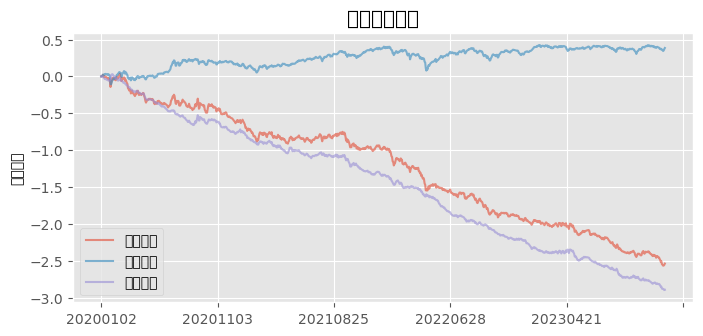

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.746,-0.654
年化波动率,0.201,0.179,0.297
夏普率,0.495,-4.173,-2.199
最大回撤,-0.325,-2.927,-2.601
收益回撤比,0.305,-0.255,-0.252
胜率,0.534,0.396,0.453
盈亏比,0.948,0.768,0.838


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


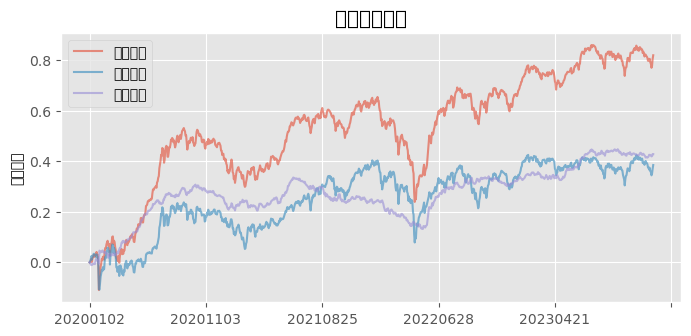

,指数收益,超额收益,策略收益
年化收益率,0.099,0.110,0.211
年化波动率,0.201,0.083,0.210
夏普率,0.495,1.333,1.007
最大回撤,-0.325,-0.203,-0.415
收益回撤比,0.305,0.544,0.509
胜率,0.534,0.518,0.557
盈亏比,0.948,1.171,0.944


In [39]:
transformed_factor = []
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
    transformed_factor_X = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)
    a = ff.run(-transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    b = ff.run(transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    if a.iloc[0,2] > 0:
        result.loc[len(result)] = ('-'+str(program),a.iloc[2,2],a.iloc[0,2],10)
    else:
        result.loc[len(result)] = (str(program),b.iloc[2,2],b.iloc[0,2],10)

In [40]:
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    if i == 6:
        transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
        transformed_factor_X_5 = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)

Program 1: add(add(max_(up_plus_down_KURS, SMTR), foc_Comb), stddev_cov_right)
Program 2: max_(delay1(div(ts_chg5(excess30), ts_zscore5(WBGM))), add(max_(up_plus_down_KURS, SMTR), sub(turnoverf, high)))
Program 3: neg(add(abs(SPR), turnover))
Program 4: log(add(add(delay1(roc121), foc_Comb), stddev_cov_right))
Program 5: add(buy_md_amount, max_(turnover_scale_z, STR))
Program 6: add(turnoverf_mean, sub(turnoverf, high))
Program 7: max_(max_(up_plus_down_KURS, SMTR), max_(bias15, vol_std))
Program 8: add(log(sell_md_amount), sqrt(SMTR))
Program 9: sub(add(turnoverf_mean, market_mean_IV), high)
Program 10: add(min_(SPS, sell_lg_amount), sub(std, up_limit))


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0005
交易模式： t日收盘价买入，收盘价卖出


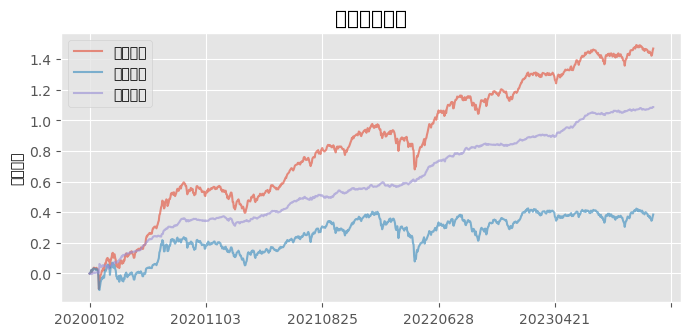

,指数收益,超额收益,策略收益
年化收益率,0.099,0.280,0.379
年化波动率,0.201,0.070,0.215
夏普率,0.495,4.016,1.763
最大回撤,-0.325,-0.063,-0.297
收益回撤比,0.305,4.471,1.276
胜率,0.534,0.604,0.572
盈亏比,0.948,1.366,1.012


,指数收益,超额收益,策略收益
年化收益率,0.099,0.280,0.379
年化波动率,0.201,0.070,0.215
夏普率,0.495,4.016,1.763
最大回撤,-0.325,-0.063,-0.297
收益回撤比,0.305,4.471,1.276
胜率,0.534,0.604,0.572
盈亏比,0.948,1.366,1.012


In [42]:
ff.run(transformed_factor_X_5*ff.filter1.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0.0005)[0]

In [24]:
(transformed_factor_X_5*ff.filter1.loc[:,'20200101':'20240101'])['20231228'].sort_values()

689009.SH     -0.560199
688069.SH     50.321556
603385.SH    100.879221
603898.SH    107.019739
603955.SH    114.105719
                ...    
873726.BJ           NaN
873806.BJ           NaN
873833.BJ           NaN
920002.BJ           NaN
T00018.SH           NaN
Name: 20231228, Length: 5544, dtype: float64

In [25]:
transformed_factor_X_5.sum()

20200102    2.386139e+07
20200103    2.281903e+07
20200106    2.644666e+07
20200107    2.422794e+07
20200108    2.595384e+07
                ...     
20231225    2.035913e+07
20231226    2.071961e+07
20231227    2.136483e+07
20231228    2.917934e+07
20231229    2.749055e+07
Length: 970, dtype: float64

In [26]:
ll = pd.DataFrame(ff.read('ll30'),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)
(ll.rank()/ll.count()).values.reshape(-1)
bb = pd.DataFrame(ff.read('bias15'),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)
(bb.rank()/bb.count()).values.reshape(-1)

array([0.44095745, 0.3712766 , 0.49508371, ...,        nan,        nan,
              nan])

In [27]:
event = pd.DataFrame(np.nan_to_num(bb) + np.nan_to_num(ll),index = close.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


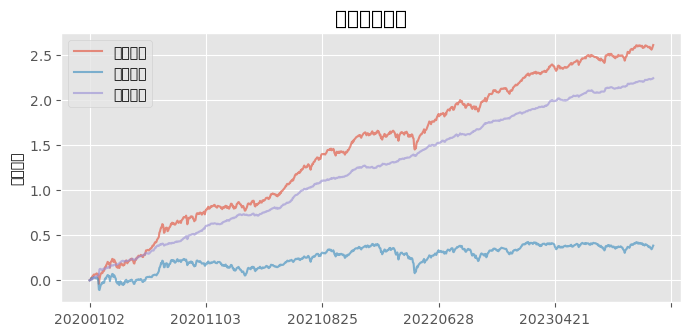

,指数收益,超额收益,策略收益
年化收益率,0.099,0.578,0.673
年化波动率,0.201,0.086,0.237
夏普率,0.495,6.726,2.845
最大回撤,-0.325,-0.033,-0.209
收益回撤比,0.305,17.346,3.218
胜率,0.534,0.700,0.604
盈亏比,0.948,1.451,1.060


,指数收益,超额收益,策略收益
年化收益率,0.099,0.578,0.673
年化波动率,0.201,0.086,0.237
夏普率,0.495,6.726,2.845
最大回撤,-0.325,-0.033,-0.209
收益回撤比,0.305,17.346,3.218
胜率,0.534,0.700,0.604
盈亏比,0.948,1.451,1.060


In [28]:
ff.run(event*ff.filter1.loc[:,'20200101':'20240430'], positions = 100, period = 1, fees = 0)[0]

In [29]:
event = pd.DataFrame(np.nan_to_num(bb) + np.nan_to_num(ll),index = close.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)

In [30]:
event[event.index.str.startswith('30') | event.index.str.startswith('68')] = 0

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0005
交易模式： t日收盘价买入，收盘价卖出


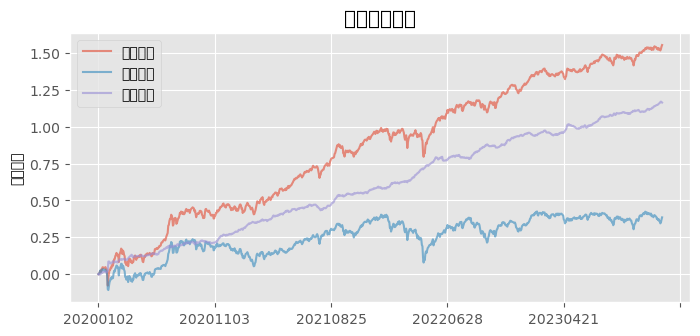

,指数收益,超额收益,策略收益
年化收益率,0.099,0.300,0.401
年化波动率,0.201,0.071,0.205
夏普率,0.495,4.238,1.959
最大回撤,-0.325,-0.039,-0.196
收益回撤比,0.305,7.713,2.046
胜率,0.534,0.623,0.590
盈亏比,0.948,1.272,0.974


,指数收益,超额收益,策略收益
年化收益率,0.099,0.300,0.401
年化波动率,0.201,0.071,0.205
夏普率,0.495,4.238,1.959
最大回撤,-0.325,-0.039,-0.196
收益回撤比,0.305,7.713,2.046
胜率,0.534,0.623,0.590
盈亏比,0.948,1.272,0.974


In [31]:
ff.run(event*ff.filter1.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0.0005)[0]

In [32]:
(event*ff.filter1.loc[:,'20200101':'20240101'])['20231228'].dropna().sort_values()

603733.SH    -0.009453
600493.SH    -0.009100
601678.SH    -0.007095
601107.SH    -0.006948
601880.SH    -0.006924
               ...    
600178.SH     9.999332
605577.SH    10.014702
603536.SH    11.000000
603721.SH    12.002188
603598.SH    12.007886
Name: 20231228, Length: 4827, dtype: float64

In [33]:
market_open = pd.read_pickle('/home/wangs/data/market_ls.pk')

In [34]:
close_ = ff.read('close').loc[:,'20200101':'20240101']

In [35]:
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)

In [36]:
axes_list = []
for j in [10,20,30,50,100]:
    ret_all = []
    for day in event.columns:
        buy_stock =  (event*ff.filter1.loc[:,'20200101':'20240101'])[day].dropna().sort_values().head(j).index
        ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
    ret_all[-1] = 0.0
    print(ff.cal_returns(pd.Series(ret_all,index=event.columns)))

{'年化收益率': 0.373651123089372, '年化波动率': 0.26359009378879766, '夏普率': 1.4175461517486354, '最大回撤': -0.2216520827709232, '收益回撤比': 1.685755073529083, '胜率': 0.542, '盈亏比': 1.067225654355991}
{'年化收益率': 0.42655315197082216, '年化波动率': 0.22958673317720574, '夏普率': 1.857917250129556, '最大回撤': -0.18261587641276722, '收益回撤比': 2.3357944574692002, '胜率': 0.552, '盈亏比': 1.108236454967248}
{'年化收益率': 0.501463416708021, '年化波动率': 0.2189564888977797, '夏普率': 2.2902423181535863, '最大回撤': -0.16248304270091973, '收益回撤比': 3.0862507765260014, '胜率': 0.574, '盈亏比': 1.0916747018438555}
{'年化收益率': 0.5426285908736185, '年化波动率': 0.21026559384422863, '夏普率': 2.580681798447799, '最大回撤': -0.1636659268082239, '收益回撤比': 3.315464626363222, '胜率': 0.576, '盈亏比': 1.1444583733994025}
{'年化收益率': 0.5451119549199551, '年化波动率': 0.20388708150648197, '夏普率': 2.6735973210868926, '最大回撤': -0.16324248172086975, '收益回撤比': 3.3392775530823435, '胜率': 0.603, '盈亏比': 1.0428304586150066}


{'年化收益率': 0.373651123089372, '年化波动率': 0.26359009378879766, '夏普率': 1.4175461517486354, '最大回撤': -0.2216520827709232, '收益回撤比': 1.685755073529083, '胜率': 0.542, '盈亏比': 1.067225654355991}


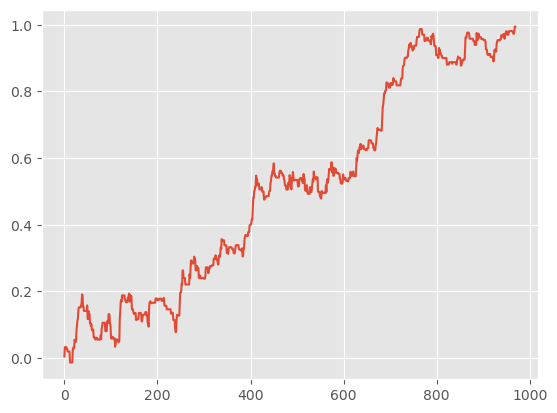

{'年化收益率': 0.42655315197082216, '年化波动率': 0.22958673317720574, '夏普率': 1.857917250129556, '最大回撤': -0.18261587641276722, '收益回撤比': 2.3357944574692002, '胜率': 0.552, '盈亏比': 1.108236454967248}


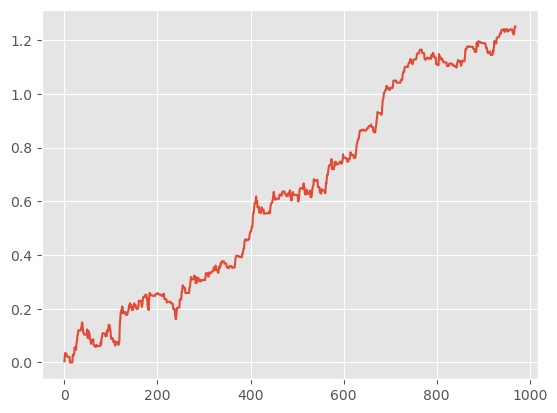

{'年化收益率': 0.501463416708021, '年化波动率': 0.2189564888977797, '夏普率': 2.2902423181535863, '最大回撤': -0.16248304270091973, '收益回撤比': 3.0862507765260014, '胜率': 0.574, '盈亏比': 1.0916747018438555}


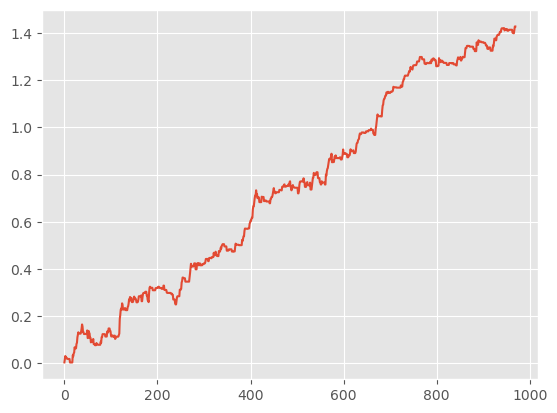

{'年化收益率': 0.5426285908736185, '年化波动率': 0.21026559384422863, '夏普率': 2.580681798447799, '最大回撤': -0.1636659268082239, '收益回撤比': 3.315464626363222, '胜率': 0.576, '盈亏比': 1.1444583733994025}


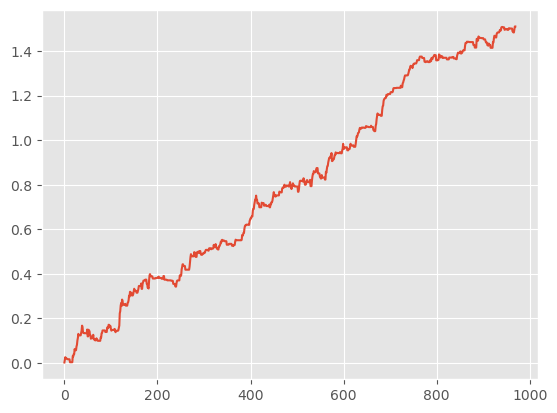

{'年化收益率': 0.5451119549199551, '年化波动率': 0.20388708150648197, '夏普率': 2.6735973210868926, '最大回撤': -0.16324248172086975, '收益回撤比': 3.3392775530823435, '胜率': 0.603, '盈亏比': 1.0428304586150066}


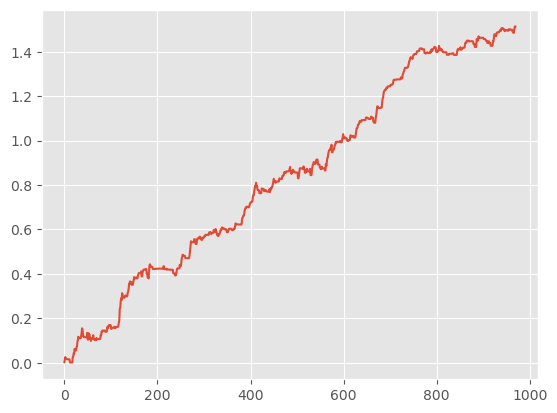

In [37]:
axes_list = []
for j in [10,20,30,50,100]:
    ret_all = []
    for day in event.columns:
        buy_stock =  (event*ff.filter1.loc[:,'20200101':'20240101'])[day].dropna().sort_values().head(j).index
        ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
    ret_all[-1] = 0.0
    print(ff.cal_returns(pd.Series(ret_all,index=event.columns)))
    ret_sum = np.cumsum(ret_all * market_open['20200102':'20240101'].values)
    plt.plot(ret_sum)
    plt.show()